In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree #For Decision Tree
import pydotplus # To create our Decision Tree Graph
from IPython.display import Image  # To Display a image of our graph

%matplotlib inline

'''
Author: Deena Bleich
Class: BIOF509
The Therapeutical Applicable Research to Generate Effective Treatments (TARGET) program studies childhood cancers
and has produced datasets containing demographic and clinical data of these patients, including vital status (alive, dead). 
This pprogram explores whether that data can be used to create a model, using supervised learning, to predict vital status
given a set of demographic or clinical features.

'''

'\nAuthor: Deena Bleich\nClass: BIOF509\nThe Therapeutical Applicable Research to Generate Effective Treatments (TARGET) program studies childhood cancers\nand has produced datasets containing demographic and clinical data of these patients, including vital status (alive, dead). \nThis pprogram explores whether that data can be used to create a model, using supervised learning, to predict vital status\ngiven a set of demographic or clinical features.\n\n'

In [2]:
class project:
    # project loads, manipulates, and analyzes a given dataset
    def __init__(self, csv):
        ''' the __init__ function is automatically called when you create
        an instance of the class. Variables or attributes of a class are
        referred to using self.__ and are accessible by all the methods, and
        by the user outside of the class definition'''
   
        ''' Read in the TARGET Study data
        The Therapeutically Applicable Research to Generate Effective Treatments (TARGET) program studies childhood cancers. 
        This data was stored in the Google BigQuery project isb-cgc.TARGET_bioclin_v0.clinical_v1'''

        try:
          df = pd.read_csv(csv, low_memory=False)
          self.data = df
  
        except:
          print("The file {0} was not found or could not be read".format(csv))
    

In [3]:
'''Function to select our features'''
def select_features(df_clin, feature_list):
    new_df = df_clin[feature_list]
        
    return new_df

In [4]:
'''Split dataframe into features and labels'''
def create_features_and_labels(df):
    
    #drop nan frm vital_status, as vital_status will be the label
    new_df = df.dropna(subset=['vital_status'])
    new_df = new_df.reset_index(drop = True)
    
    #separate out the features from the labels.
    
    #Get just the vital_statuses, which will be the labels
    vital_statuses = new_df["vital_status"].to_list()
    #turn the vital status to binary values 0 and 1; alive = 0, dead = 1
    vital_status_codes, vital_status_factors = pd.factorize(vital_statuses)
   
    #Get just the features
    features_df = new_df.drop(columns=["vital_status"])
    
    return features_df, vital_status_codes

In [5]:
'''Function to encode features - feature set "clin" '''
def encode_categorical_features2(features_df):

    #hot encode each categorical feature
    df_disease = pd.get_dummies(features_df['disease_code'], prefix='disease')
    df_INSS_stage = pd.get_dummies(features_df['INSS_stage'], prefix='INSS_stage')
    df_first_event = pd.get_dummies(features_df['first_event'], prefix='first_event')
    df_histology = pd.get_dummies(features_df['histology'], prefix='histology')
    df_MYCN = pd.get_dummies(features_df['MYCN_status'], prefix='MYCN')

    #Add these new features to the features dataframe and drop the columns that they were derived from
    encoded_feature_df = pd.concat([features_df, df_disease, df_INSS_stage, df_first_event, df_histology, df_MYCN], axis =1)
    encoded_feature_df = encoded_feature_df.drop(columns=['disease_code', 'INSS_stage', 'first_event','histology', 'MYCN_status'])
    
    return encoded_feature_df

In [6]:
'''Function to encode features - feature set "demog" '''
def encode_categorical_features1(features_df):

    #hot encode each categorical feature
    df_disease = pd.get_dummies(features_df['disease_code'], prefix='disease')
    df_gender = pd.get_dummies(features_df['gender'], prefix='gender')
    df_race = pd.get_dummies(features_df['race'], prefix='race')
    df_ethnicity = pd.get_dummies(features_df['ethnicity'], prefix='ethnicity')

    #Add these new features to the features dataframe and drop the columns that they were derived from
    encoded_feature_df = pd.concat([features_df, df_disease, df_gender, df_race, df_ethnicity], axis =1)
    encoded_feature_df = encoded_feature_df.drop(columns=['disease_code', 'gender', 'race', 'ethnicity'])    
    
    return encoded_feature_df

In [7]:
'''Scale features'''
def scale_features(features_df):

    data_for_scaling = features_df.values
    scaler = MinMaxScaler()
    scaled_feature_data = scaler.fit_transform(data_for_scaling)
    
    return scaled_feature_data

In [8]:
'''Random Forest Classifer'''
def randomForest(num_of_feature_cols, feature_data, vital_status_codes):

    rf_model = RandomForestClassifier(n_estimators = 64)

    #split our dataset into 5 parts, and each part will get a turn being the test dataset
    skf = StratifiedKFold(n_splits=5)

    accuracy = 0

    #Each test set will have slightly different feature importances so sum the results for each feature
    all_feature_importances = np.zeros(num_of_feature_cols)

    #keep track of the labels from the random test sets in order to make a confusion matrix
    all_labels = []

    #keep track of the predictions from the random test sets in order to make a confusion matrix '''
    all_predictions = []

    for train_index, test_index in skf.split(feature_data, vital_status_codes):
    
        #training dataset
        X_train, y_train = feature_data[train_index], vital_status_codes[train_index]

        #testing dataset
        X_test, y_test = feature_data[test_index], vital_status_codes[test_index]

        rf_model.fit(X_train,y_train)
        
        #add the new feature importances to the current FI vlues
        all_feature_importances += rf_model.feature_importances_
        
        predictions = rf_model.predict(X_test)
        
        #add the new predictions onto the list of predictions
        all_predictions.extend(predictions)
        
        #add the new predictions onto the list of predictions
        all_labels.extend(y_test)
        
        accuracy += accuracy_score(predictions,y_test)
        
        return accuracy, all_predictions, all_labels, all_feature_importances
        

In [9]:
'''Decision Tree Classifer'''
def decisionTree(num_of_feature_cols, feature_data, vital_status_codes):

    clf_model = tree.DecisionTreeClassifier()

    #split our dataset into 5 parts, and each part will get a turn being the test dataset
    skf = StratifiedKFold(n_splits=5)

    accuracy = 0

    #Each test set will have slightly different feature importances so sum the results for each feature
    all_feature_importances = np.zeros(num_of_feature_cols)

    #keep track of the labels from the random test sets in order to make a confusion matrix
    all_labels = []

    #keep track of the predictions from the random test sets in order to make a confusion matrix '''
    all_predictions = []

    for train_index, test_index in skf.split(feature_data, vital_status_codes):
    
        #training dataset
        X_train, y_train = feature_data[train_index], vital_status_codes[train_index]

        #testing dataset
        X_test, y_test = feature_data[test_index], vital_status_codes[test_index]

        clf_model.fit(X_train,y_train)
        
        #add the new feature importances to the current FI vlues
        all_feature_importances += clf_model.feature_importances_
        
        predictions = clf_model.predict(X_test)
        
        #add the new predictions onto the list of predictions
        all_predictions.extend(predictions)
        
        #add the new predictions onto the list of predictions
        all_labels.extend(y_test)
        
        accuracy += accuracy_score(predictions,y_test)
        
        return accuracy, all_predictions, all_labels, clf_model
        

In [10]:
'''UMAP Dimensionality Reduction'''
def UMAPreduce(feature_data):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(scaled_feature_data)
    
    return embedding

In [14]:
'''
The main program, which creates the supervised learning model of choice with the selected feature set.
It displays the model's accuracy score and the confusion matrix.
'''

def modelTARGETdata(csv, feature_set, model_type):
    df_clinical = project(csv)
    df_clin = df_clinical.data
    
    #Feature Set "demog" is mainly demographic; Feature Set "clin" is mainly clinical.
    if feature_set == "demog":
        feature_list = ["disease_code", "age_at_diagnosis", "gender", "race", "ethnicity", "vital_status"]
    else:
        feature_list = ["disease_code", "age_at_diagnosis", "INSS_stage", "first_event", "histology", "MYCN_status", "vital_status"]
        
    #create new dataframe that only has the features which we are interested in
    new_df = select_features(df_clin, feature_list)
    
    #Separate the features from the labels (vital_status of alive, dead)
    features_df, vital_status_codes = create_features_and_labels(new_df)
    
    ##Hot Encode Categorical Data
    if feature_set == "demog":
       encoded_features_df = encode_categorical_features1(features_df)
    else:
       encoded_features_df = encode_categorical_features2(features_df)
    
    ##Scale features -- need to scale Age at Diagnosis
    scaled_feature_data = scale_features(encoded_features_df)
    
    ##Run the Supervised Learning Model of choice on the features of choice and print out accuracy and the confusion matrix
    
    if model_type == 'RF':
        #Perform Random Forest Classification
        accuracy, all_predictions, all_labels, all_feature_importances = randomForest(len(encoded_features_df.columns), scaled_feature_data, vital_status_codes)
        print('Success! Random Forest Classification has completed, with Accuracy:')
        print(accuracy)
        print()
        print('The Confusion Matrix shows the accuracy per label (Alive in top left, Dead in bottom right).')
        #Create a confusion matrix of all the labels against all the predictions
        cm = confusion_matrix(all_labels,all_predictions,normalize= 'true')
        #turn it into a dataframe so seaborn will label the graph using the columns/indicies of the dataframe
        df_cm = pd.DataFrame(cm,index=[0,1],columns=[0,1])
        #graph using seaborn heatmap function
        sns.heatmap(df_cm, annot=True)
    else:
        #Perform Decision Tree Classification
        accuracy, all_predictions, all_labels, clf_model = decisionTree(len(encoded_features_df.columns), scaled_feature_data, vital_status_codes)
        print('Success! Decision Tree Classification has completed, with Accuracy:')
        print(accuracy)
        print()
        print('The Confusion Matrix shows the accuracy per label (Alive in top left, Dead in bottom right).')
        #Create a confusion matrix of all the labels against all the predictions
        cm = confusion_matrix(all_labels,all_predictions,normalize= 'true')
        #turn it into a dataframe so seaborn will label the graph using the columns/indicies of the dataframe
        df_cm = pd.DataFrame(cm,index=[0,1],columns=[0,1])
        #graph using seaborn heatmap function
        sns.heatmap(df_cm, annot=True)
    

Success! Decision Tree Classification has completed, with Accuracy:
0.8725274725274725

The Confusion Matrix shows the accuracy per label (Alive in top left, Dead in bottom right).


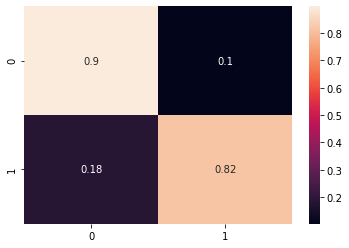

In [15]:
'''
Run the main program.
##Run the Supervised Learning Model of choice on the features of choice and print out accuracy and the confusion matrix.
## Vital Status is the label and all other attributes are the features used to train the model.

Parameter 1: TARGET Demographic and Clinical Data File
Parameter 2: Feature Set
                "demog" = "disease_code", "age_at_diagnosis", "gender", "race", "ethnicity", "vital_status"
                "clin" = "disease_code", "age_at_diagnosis", "INSS_stage", "first_event", "histology", "MYCN_status", "vital_status"
Parameter 3: Model Type
                "RF" = Random Forest
                "DT" = Decision Tree
'''

modelTARGETdata('TARGET-Clinical-All.csv', "clin", "DT")

In [16]:
'''
Run each step separately (in sequence) if you'd like to see the results of each cell. 
Also, you can run UMAP, create feature importance graphs and the Decision Tree graph in these steps, which are not 
included in the main program modelTARGETdata.
'''

"\nRun each step separately (in sequence) if you'd like to see the results of each cell. \nAlso, you can run UMAP, create feature importance graphs and the Decision Tree graph in these steps, which are not \nincluded in the main program modelTARGETdata.\n"

In [17]:
# Create an instance of the project class
df_clinical = project('TARGET-Clinical-All.csv')
df_clin = df_clinical.data

df_clin.head(5)

case_barcode                           case_gdc_id program_name  \
0  TARGET-30-PATSRD  fef92ed0-242b-5564-ad92-6b35c21c3bd5       TARGET   
1  TARGET-30-PAUAZA  fe831368-c7ce-5e2b-b0fd-c35216a7761d       TARGET   
2  TARGET-30-PASWIJ  fe0b727f-3843-5b70-b9c1-8a207b837fc4       TARGET   
3  TARGET-30-PANBMJ  fdfb389d-eb9a-5014-b391-9cd5f908720d       TARGET   
4  TARGET-30-PAPDIM  fdc610fa-6de9-5aec-bc20-a9a44b47d4e4       TARGET   

  program_dbgap_accession_number project_short_name   project_name  \
0                      phs000218         TARGET-NBL  Neuroblastoma   
1                      phs000218         TARGET-NBL  Neuroblastoma   
2                      phs000218         TARGET-NBL  Neuroblastoma   
3                      phs000218         TARGET-NBL  Neuroblastoma   
4                      phs000218         TARGET-NBL  Neuroblastoma   

  disease_code  gender vital_status                       race  ...  \
0          NBL    Male        alive  Black or African American  ...   
1          NBL  Female        alive                      White  ...   
2          NBL    Male        alive                      White  ...   
3          NBL    Male         dead                      White  ...   
4          NBL  Female         dead  Black or African American  ...   

  alternate_therapy_other  metastasis_site  primary_site_progression  \
0                     NaN              NaN                       NaN   
1                     NaN              NaN                       NaN   
2                     NaN              NaN                       NaN   
3                     NaN              NaN                       NaN   
4                     NaN              NaN                       NaN   

   refractory_timepoint_sent_for_induction_failure_project  \
0                                                NaN         
1                                                NaN         
2                                                NaN         
3                                                NaN         
4                                                NaN         

   relapse_percent_necrosis  relapse_percent_tumor relapse_type  therapy  \
0                       NaN                    NaN          NaN      NaN   
1                       NaN                    NaN          NaN      NaN   
2                       NaN                    NaN          NaN      NaN   
3                       NaN                    NaN          NaN      NaN   
4                       NaN                    NaN          NaN      NaN   

   time_to_first_SMN_in_days  \
0                        NaN   
1                        NaN   
2                        NaN   
3                        NaN   
4                        NaN   

   time_to_first_enrollment_on_relapse_protocol_in_days  
0                                                NaN     
1                                                NaN     
2                                                NaN     
3                                                NaN     
4                                                NaN     

[5 rows x 130 columns]

In [18]:
#create new dataframe that only has the features which we are interested in
#Change the Feature Set to the one you want to use.

''' 
Set your Feature Set
"demog" = "disease_code", "age_at_diagnosis", "gender", "race", "ethnicity", "vital_status"
"clin" = "disease_code", "age_at_diagnosis", "INSS_stage", "first_event", "histology", "MYCN_status", "vital_status"
'''
feature_set = "clin"


 #Feature Set "demog" is mainly demographic; Feature Set "clin" is mainly clinical
if feature_set == "demog":
    feature_list = ["disease_code", "age_at_diagnosis", "gender", "race", "ethnicity", "vital_status"]
else:
    feature_list = ["disease_code", "age_at_diagnosis", "INSS_stage", "first_event", "histology", "MYCN_status", "vital_status"]

new_df = select_features(df_clin, feature_list)

new_df.head(5)

disease_code  age_at_diagnosis INSS_stage first_event    histology  \
0          NBL               3.0    Stage 4    Censored  Unfavorable   
1          NBL               1.0    Stage 4    Censored  Unfavorable   
2          NBL               6.0    Stage 4    Censored  Unfavorable   
3          NBL               2.0    Stage 4     Relapse  Unfavorable   
4          NBL               3.0    Stage 4       Event  Unfavorable   

     MYCN_status vital_status  
0      Amplified        alive  
1  Not Amplified        alive  
2  Not Amplified        alive  
3  Not Amplified         dead  
4  Not Amplified         dead

In [19]:
#Separate the features from the labels (vital_status of alive, dead)
features_df, vital_status_codes = create_features_and_labels(new_df)

features_df.head(10)


disease_code  age_at_diagnosis INSS_stage  first_event    histology  \
0          NBL               3.0    Stage 4     Censored  Unfavorable   
1          NBL               1.0    Stage 4     Censored  Unfavorable   
2          NBL               6.0    Stage 4     Censored  Unfavorable   
3          NBL               2.0    Stage 4      Relapse  Unfavorable   
4          NBL               3.0    Stage 4        Event  Unfavorable   
5          NBL               6.0    Stage 3  Progression  Unfavorable   
6          NBL               2.0    Stage 4        Event          NaN   
7          NBL               5.0    Stage 4      Relapse  Unfavorable   
8          NBL               5.0    Stage 4     Censored  Unfavorable   
9          NBL               4.0    Stage 4     Censored  Unfavorable   

     MYCN_status  
0      Amplified  
1  Not Amplified  
2  Not Amplified  
3  Not Amplified  
4  Not Amplified  
5  Not Amplified  
6      Amplified  
7  Not Amplified  
8  Not Amplified  
9  Not Amplified

In [20]:
##Hot Encode Categorical Data

if feature_set == "demog":
   encoded_features_df = encode_categorical_features1(features_df)
else:
   encoded_features_df = encode_categorical_features2(features_df)
 
encoded_features_df.head(10)

age_at_diagnosis  disease_ALL  disease_AML  disease_CCSK  disease_NBL  \
0               3.0            0            0             0            1   
1               1.0            0            0             0            1   
2               6.0            0            0             0            1   
3               2.0            0            0             0            1   
4               3.0            0            0             0            1   
5               6.0            0            0             0            1   
6               2.0            0            0             0            1   
7               5.0            0            0             0            1   
8               5.0            0            0             0            1   
9               4.0            0            0             0            1   

   disease_OS  disease_RT  disease_WT  INSS_stage_Stage 1  \
0           0           0           0                   0   
1           0           0           0                   0   
2           0           0           0                   0   
3           0           0           0                   0   
4           0           0           0                   0   
5           0           0           0                   0   
6           0           0           0                   0   
7           0           0           0                   0   
8           0           0           0                   0   
9           0           0           0                   0   

   INSS_stage_Stage 2a  ...  first_event_Second Malignant Neoplasm  \
0                    0  ...                                      0   
1                    0  ...                                      0   
2                    0  ...                                      0   
3                    0  ...                                      0   
4                    0  ...                                      0   
5                    0  ...                                      0   
6                    0  ...                                      0   
7                    0  ...                                      0   
8                    0  ...                                      0   
9                    0  ...                                      0   

   histology_CCSK  histology_DAWT  histology_FHWT  histology_Favorable  \
0               0               0               0                    0   
1               0               0               0                    0   
2               0               0               0                    0   
3               0               0               0                    0   
4               0               0               0                    0   
5               0               0               0                    0   
6               0               0               0                    0   
7               0               0               0                    0   
8               0               0               0                    0   
9               0               0               0                    0   

   histology_MXED  histology_RT  histology_Unfavorable  MYCN_Amplified  \
0               0             0                      1               1   
1               0             0                      1               0   
2               0             0                      1               0   
3               0             0                      1               0   
4               0             0                      1               0   
5               0             0                      1               0   
6               0             0                      0               1   
7               0             0                      1               0   
8               0             0                      1               0   
9               0             0                      1               0   

   MYCN_Not Amplified  
0                   0  
1                   1  
2                   1

In [21]:
##Scale features -- need to scale Age at Diagnosis
scaled_feature_data = scale_features(encoded_features_df)

scaled_feature_data

array([[0.07692308, 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.02564103, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.15384615, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.02564103, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.12820513, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.15384615, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ]])

In [22]:
len(encoded_features_df.columns)

31

In [24]:
#Perform Random Forest Classification
accuracy, all_predictions, all_labels, all_feature_importances = randomForest(len(encoded_features_df.columns), scaled_feature_data, vital_status_codes)

print('Success! Random Forest Classification has completed, with Accuracy:')
print(accuracy)


Success! Random Forest Classification has completed, with Accuracy:
0.8593406593406593


The Confusion Matrix shows the accuracy per label (Alive in top left, Dead in bottom right).


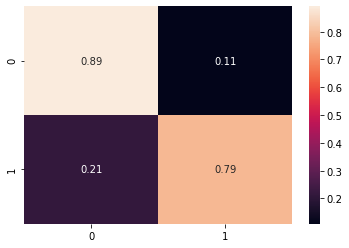

In [25]:
#Create a confusion matrix of all the labels against all the predictions
cm = confusion_matrix(all_labels,all_predictions,normalize= 'true')

# turn it into a dataframe so seaborn will label the graph using the columns/indicies of the dataframe
df_cm = pd.DataFrame(cm,index=[0,1],columns=[0,1])

print('The Confusion Matrix shows the accuracy per label (Alive in top left, Dead in bottom right).')
#graph using seaborn heatmap function
sns.heatmap(df_cm, annot=True)

Text(0.5, 1.0, 'Feature Importances')

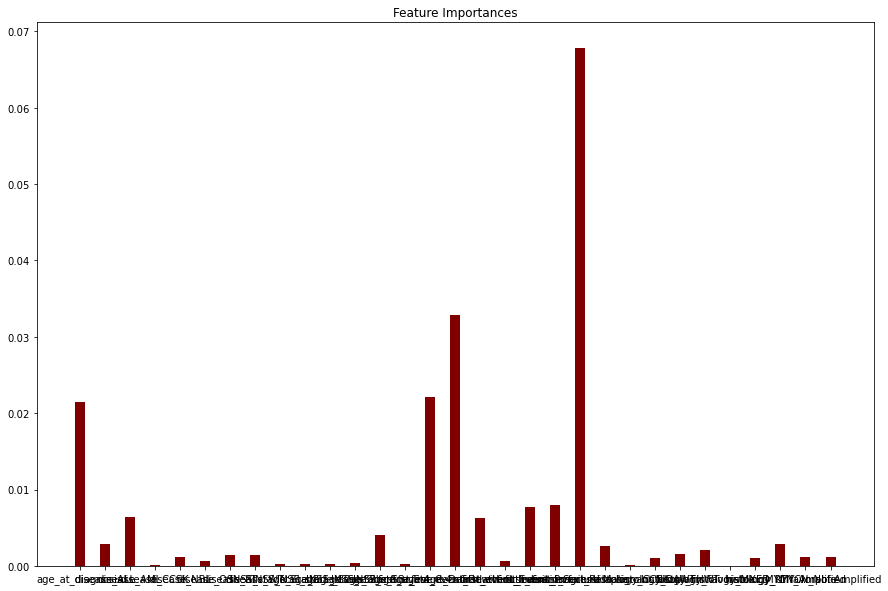

In [26]:
# graph feature importances, X axis = feature name, y axis = feature importance values
plt.figure(figsize = (15,10))
plt.bar(list(encoded_features_df.columns),all_feature_importances/5, color ='maroon',  width = .4) 
#plt.bar(all_feature_importances/5, list(encoded_features_df.columns), color ='maroon', width = 1)
plt.title('Feature Importances')

In [27]:
#Let's try sending it through UMAP and see if it makes a difference.
embedding = UMAPreduce(scaled_feature_data)

embedding.shape

(4548, 2)

Text(0.5, 1.0, 'UMAP projection of the clinical dataset')

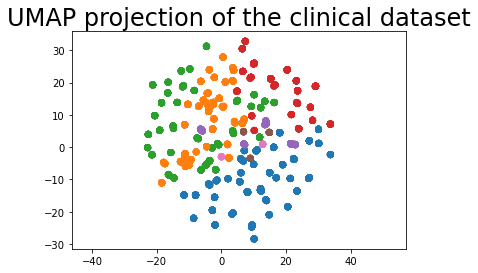

In [28]:
#Plot the UMAP projection
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in features_df.disease_code.map({"ALL":0, "NBL":1, "AML":2, "WT":3, "OS":4, "RT":5, "CCSK":6})])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the clinical dataset', fontsize=24)

In [29]:
#Perform Decision Tree Classification
accuracy, all_predictions, all_labels, clf_model = decisionTree(len(encoded_features_df.columns), scaled_feature_data, vital_status_codes)

print('Success! Random Forest Classification has completed, with Accuracy:')
print(accuracy)

Success! Random Forest Classification has completed, with Accuracy:
0.8615384615384616


The Confusion Matrix shows the accuracy per label (Alive in top left, Dead in bottom right).


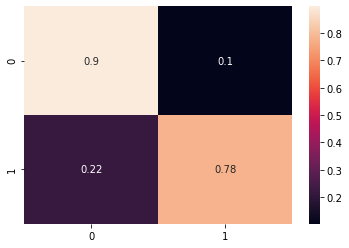

In [30]:
#Create a confusion matrix of all the labels against all the predictions
cm = confusion_matrix(all_labels,all_predictions,normalize= 'true')

# turn it into a dataframe so seaborn will label the graph using the columns/indicies of the dataframe
df_cm = pd.DataFrame(cm,index=[0,1],columns=[0,1])

print('The Confusion Matrix shows the accuracy per label (Alive in top left, Dead in bottom right).')
#graph using seaborn heatmap function
sns.heatmap(df_cm, annot=True)

digraph Tree {
node [shape=box] ;
0 [label="X[20] <= 0.5\ngini = 0.424\nsamples = 3638\nvalue = [2530, 1108]"] ;
1 [label="X[15] <= 0.5\ngini = 0.259\nsamples = 2545\nvalue = [2156, 389]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="X[18] <= 0.5\ngini = 0.159\nsamples = 2361\nvalue = [2156, 205]"] ;
1 -> 2 ;
3 [label="X[19] <= 0.5\ngini = 0.109\nsamples = 2257\nvalue = [2127, 130]"] ;
2 -> 3 ;
4 [label="X[16] <= 0.5\ngini = 0.055\nsamples = 2162\nvalue = [2101, 61]"] ;
3 -> 4 ;
5 [label="X[21] <= 0.5\ngini = 0.021\nsamples = 2124\nvalue = [2101, 23]"] ;
4 -> 5 ;
6 [label="X[17] <= 0.5\ngini = 0.009\nsamples = 2103\nvalue = [2093, 10]"] ;
5 -> 6 ;
7 [label="X[0] <= 0.167\ngini = 0.001\nsamples = 2081\nvalue = [2080, 1]"] ;
6 -> 7 ;
8 [label="gini = 0.0\nsamples = 1290\nvalue = [1290, 0]"] ;
7 -> 8 ;
9 [label="X[0] <= 0.192\ngini = 0.003\nsamples = 791\nvalue = [790, 1]"] ;
7 -> 9 ;
10 [label="X[1] <= 0.5\ngini = 0.031\nsamples = 64\nvalue = [63, 1]"] ;
9 ->

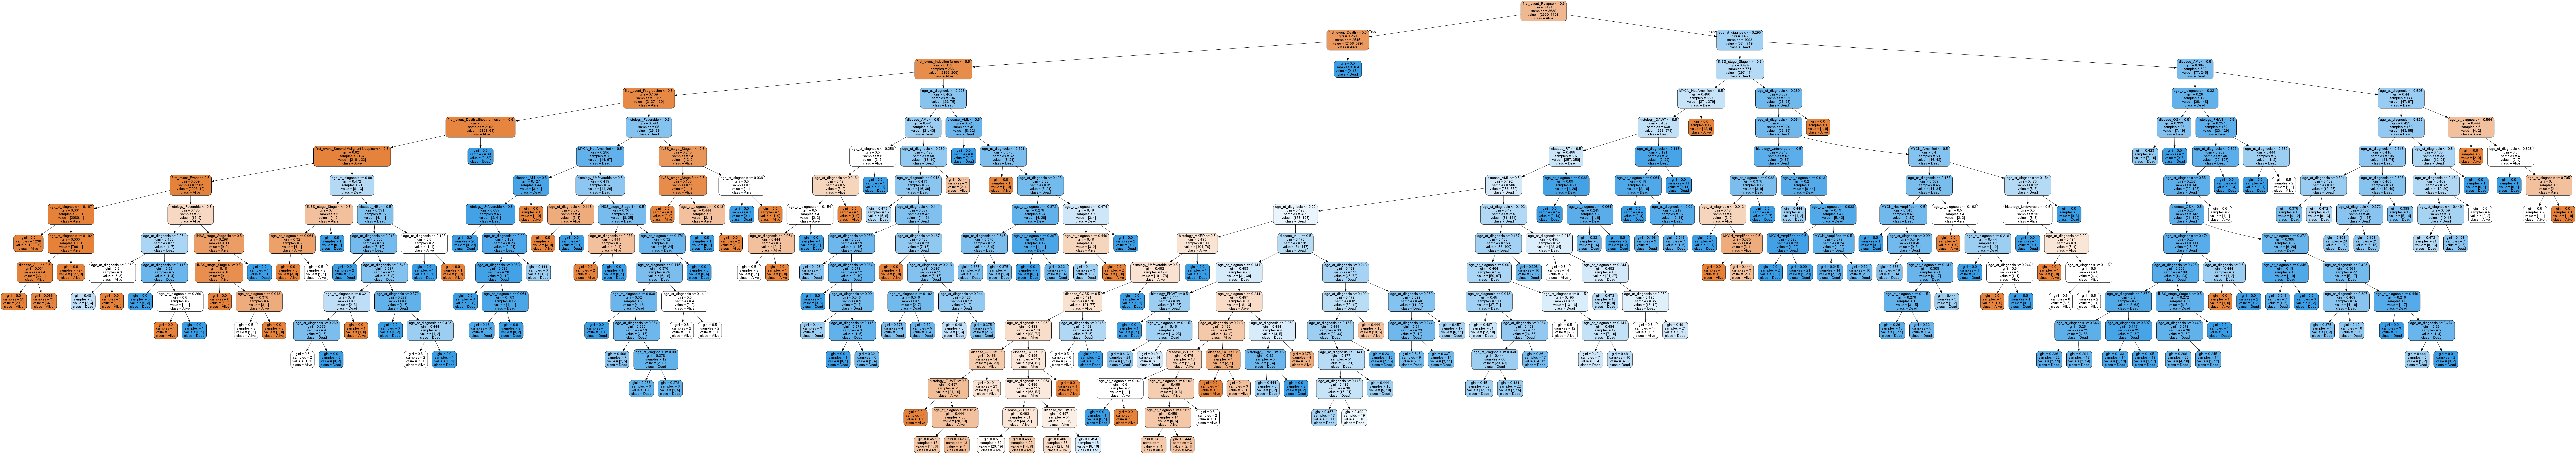

In [31]:
# Export/Print a decision tree in DOT format.
print(tree.export_graphviz(clf_model, None))

#Create Dot Data
dot_data = tree.export_graphviz(clf_model, out_file=None, feature_names=list(encoded_features_df.columns.values), 
                                class_names=['Alive', 'Dead'], rounded=True, filled=True) #Gini decides which attribute/feature should be placed at the root node, which features will act as internal nodes or leaf nodes
#Create Graph from DOT data
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())